In [1]:
!pip install -q transformers sentence-transformers faiss-cpu datasets matplotlib pandas


In [2]:
import torch
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer

from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Loading

In this experiment, we use the PubMedQA dataset, which consists of biomedical yes/no questions paired with the PubMed abstracts from which they were derived.  
We restrict our experiments to the labeled training split and randomly select 1,000 samples to ensure a controlled and reproducible evaluation setting.


In [3]:
from datasets import load_dataset

dataset_dict = load_dataset("pubmed_qa", "pqa_labeled")
dataset = dataset_dict["train"]
dataset = dataset.select(range(1000))

In [4]:
print(type(dataset))
print(type(dataset[0]))
print(dataset[0])

<class 'datasets.arrow_dataset.Dataset'>
<class 'dict'>
{'pubid': 21645374, 'question': 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?', 'context': {'contexts': ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.', 'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression

### Corpus and Query Construction

For dense retrieval evaluation, we construct a document corpus by concatenating all sentences within each abstract into a single text representation.  
Each question is treated as a query, and the corresponding abstract from which the question originates is considered the ground-truth relevant document.

This setup allows us to evaluate whether a retrieval model can successfully identify the correct supporting abstract for a given question.


In [7]:
corpus = {}
queries = {}

for i in range(len(dataset)):
    item = dataset[i]

    pubid = item["pubid"]
    question = item["question"]
    contexts = item["context"]["contexts"]

    text = " ".join(contexts)

    corpus[pubid] = text
    queries[question] = pubid


In [10]:
corpus_ids = list(corpus.keys())
corpus_texts = list(corpus.values())
query_texts = list(queries.keys())
query_gt = list(queries.values())


In [11]:
print(len(corpus_ids), len(corpus_texts))
print(len(query_texts), len(query_gt))


1000 1000
1000 1000


### Data Alignment for Retrieval Evaluation

To enable efficient indexing and evaluation, corpus identifiers, corpus texts, query texts, and ground-truth document IDs are stored in aligned lists.  
This alignment ensures that FAISS index positions can be correctly mapped back to PubMed document identifiers during retrieval evaluation.


In [12]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

### SapBERT Encoding

SapBERT is a biomedical sentence encoder specifically fine-tuned with UMLS-based synonym alignment.  
We use SapBERT to generate dense vector representations for both queries and abstracts, as it is expected to capture semantic similarity between biomedical expressions effectively.


In [13]:
sapbert = SentenceTransformer(
    "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
)

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
corpus_embeddings = sapbert.encode(
    corpus_texts,
    convert_to_numpy=True,
    show_progress_bar=True
)

query_embeddings = sapbert.encode(
    query_texts,
    convert_to_numpy=True,
    show_progress_bar=True
)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [15]:
print(corpus_embeddings.shape)
print(query_embeddings.shape)


(1000, 768)
(1000, 768)


### FAISS Indexing and Retrieval

The encoded document embeddings are indexed using FAISS with L2 distance for efficient nearest-neighbor search.  
For each query embedding, we retrieve the top-$k$ most similar document embeddings and map the retrieved indices back to their corresponding PubMed identifiers.


In [16]:
dim = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dim)

index.add(corpus_embeddings)

print("FAISS index size:", index.ntotal)


FAISS index size: 1000


### Recall@K Evaluation

Retrieval performance is evaluated using Recall@5 and Recall@10.  
Recall@K measures the proportion of queries for which the correct supporting abstract appears within the top-$K$ retrieved documents.  
This metric is well-suited for PubMedQA, as each query has exactly one ground-truth relevant document.


In [17]:
k = 10
distances, indices = index.search(query_embeddings, k)


In [19]:
retrieved_ids_sapbert = []

for row in indices:
    retrieved_ids_sapbert.append([corpus_ids[i] for i in row])

In [20]:
print(retrieved_ids_sapbert[0][:5])
print("Ground truth:", query_gt[0])


[21645374, 18222909, 19931500, 10411439, 14518645]
Ground truth: 21645374


In [21]:
def recall_at_k(retrieved, ground_truth, k):
    hits = 0
    for i in range(len(ground_truth)):
        if ground_truth[i] in retrieved[i][:k]:
            hits += 1
    return hits / len(ground_truth)


In [22]:
sapbert_r5 = recall_at_k(retrieved_ids_sapbert, query_gt, 5)
sapbert_r10 = recall_at_k(retrieved_ids_sapbert, query_gt, 10)

print("SapBERT Recall@5 :", sapbert_r5)
print("SapBERT Recall@10:", sapbert_r10)


SapBERT Recall@5 : 0.987
SapBERT Recall@10: 0.99


### PubMedBERT Encoding

PubMedBERT is a language model pre-trained on large-scale biomedical text.  
In this experiment, PubMedBERT is used as a sentence encoder by applying mean pooling over token embeddings.  
This allows us to analyze how a domain-specific language model performs in retrieval without retrieval-oriented fine-tuning.


In [23]:
from sentence_transformers import SentenceTransformer

pubmedbert = SentenceTransformer(
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [24]:
corpus_embeddings_pb = pubmedbert.encode(
    corpus_texts,
    convert_to_numpy=True,
    show_progress_bar=True
)

query_embeddings_pb = pubmedbert.encode(
    query_texts,
    convert_to_numpy=True,
    show_progress_bar=True
)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [25]:
print(corpus_embeddings_pb.shape)
print(query_embeddings_pb.shape)


(1000, 768)
(1000, 768)


In [26]:
dim = corpus_embeddings_pb.shape[1]
index_pb = faiss.IndexFlatL2(dim)

index_pb.add(corpus_embeddings_pb)
print("FAISS index size:", index_pb.ntotal)


FAISS index size: 1000


In [27]:
k = 10
distances_pb, indices_pb = index_pb.search(query_embeddings_pb, k)


In [28]:
retrieved_ids_pubmedbert = []

for row in indices_pb:
    retrieved_ids_pubmedbert.append([corpus_ids[i] for i in row])


In [29]:
print("Top-5 retrieved:", retrieved_ids_pubmedbert[0][:5])
print("Ground truth:", query_gt[0])


Top-5 retrieved: [21645374, 18222909, 16046584, 17279467, 23347337]
Ground truth: 21645374


In [30]:
pubmedbert_r5 = recall_at_k(
    retrieved_ids_pubmedbert, query_gt, 5
)

pubmedbert_r10 = recall_at_k(
    retrieved_ids_pubmedbert, query_gt, 10
)

print("PubMedBERT Recall@5 :", pubmedbert_r5)
print("PubMedBERT Recall@10:", pubmedbert_r10)


PubMedBERT Recall@5 : 0.536
PubMedBERT Recall@10: 0.604


### DPR Context Encoder

The DPR Context Encoder is designed explicitly for dense retrieval and trained on the open-domain Natural Questions dataset.  
Unlike the previous models, DPR embeddings are obtained directly from the model's pooler output, following the original DPR design.  
This experiment allows us to examine the trade-off between retrieval-specific training and domain mismatch in biomedical retrieval tasks.


In [31]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch


In [32]:
dpr_tokenizer = DPRContextEncoderTokenizer.from_pretrained(
    "facebook/dpr-ctx_encoder-single-nq-base"
)

dpr_model = DPRContextEncoder.from_pretrained(
    "facebook/dpr-ctx_encoder-single-nq-base"
)

dpr_model.eval()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DPRContextEncoder(
  (ctx_encoder): DPREncoder(
    (bert_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [38]:
def dpr_encode(texts, batch_size=16):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        inputs = dpr_tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = dpr_model(**inputs)


        embeddings = outputs.pooler_output
        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings)


In [37]:
corpus_embeddings_dpr = dpr_encode(corpus_texts)
query_embeddings_dpr = dpr_encode(query_texts)


In [39]:
print(corpus_embeddings_dpr.shape)
print(query_embeddings_dpr.shape)


(1000, 768)
(1000, 768)


In [41]:
dim = corpus_embeddings_dpr.shape[1]
index_dpr = faiss.IndexFlatL2(dim)

index_dpr.add(corpus_embeddings_dpr)
print("FAISS index size:", index_dpr.ntotal)

FAISS index size: 1000


In [42]:
k = 10
_, indices_dpr = index_dpr.search(query_embeddings_dpr, k)


In [43]:
retrieved_ids_dpr = []

for row in indices_dpr:
    retrieved_ids_dpr.append([corpus_ids[i] for i in row])


In [44]:
print("Top-5 retrieved:", retrieved_ids_dpr[0][:5])
print("Ground truth:", query_gt[0])


Top-5 retrieved: [21645374, 18222909, 15597845, 19542542, 11601252]
Ground truth: 21645374


In [45]:
dpr_r5 = recall_at_k(retrieved_ids_dpr, query_gt, 5)
dpr_r10 = recall_at_k(retrieved_ids_dpr, query_gt, 10)

print("DPR Recall@5 :", dpr_r5)
print("DPR Recall@10:", dpr_r10)


DPR Recall@5 : 0.61
DPR Recall@10: 0.682


### Comparative Results and Visualization

The retrieval results of all models are aggregated and compared using tables and bar charts.  
This comparison highlights the impact of domain alignment and retrieval-specific fine-tuning on dense retrieval performance in biomedical question answering.


In [46]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["SapBERT", "PubMedBERT", "DPR (NQ)"],
    "Recall@5": [sapbert_r5, pubmedbert_r5, dpr_r5],
    "Recall@10": [sapbert_r10, pubmedbert_r10, dpr_r10]
})

results_df


,Model,Recall@5,Recall@10
0,SapBERT,0.987,0.990
1,PubMedBERT,0.536,0.604
2,DPR (NQ),0.610,0.682


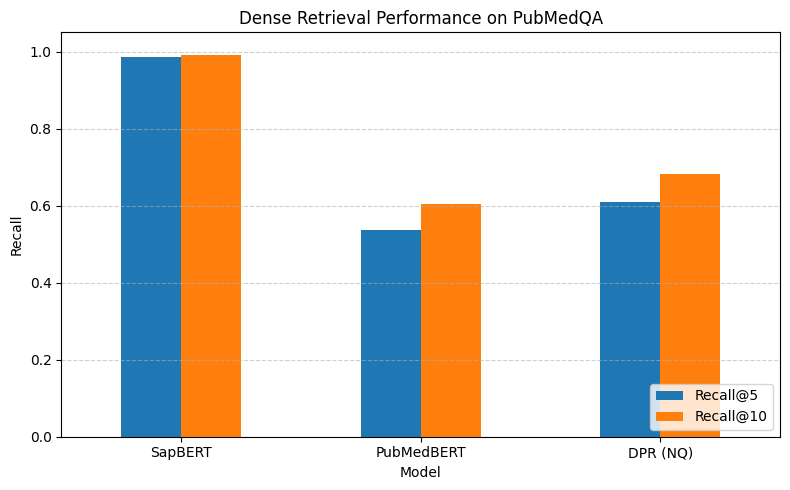

In [47]:
import matplotlib.pyplot as plt

results_df.set_index("Model").plot(
    kind="bar",
    figsize=(8,5)
)

plt.title("Dense Retrieval Performance on PubMedQA")
plt.ylabel("Recall")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [52]:
results_df["Δ (Recall@10 - Recall@5)"] = (
    results_df["Recall@10"] - results_df["Recall@5"]
)

results_df


,Model,Recall@5,Recall@10,Δ (Recall@10 - Recall@5)
0,SapBERT,0.987,0.990,0.003
1,PubMedBERT,0.536,0.604,0.068
2,DPR (NQ),0.610,0.682,0.072


### Summary of Findings

The experimental results demonstrate that SapBERT achieves near-saturated retrieval performance on PubMedQA, reflecting the importance of retrieval-oriented fine-tuning and biomedical synonym alignment.  
While PubMedBERT benefits from domain-specific pretraining, it underperforms without explicit sentence-level retrieval training.  
DPR partially compensates for domain mismatch through its retrieval-focused architecture but remains inferior to SapBERT in this biomedical setting.
